In [14]:
import lasagne
import numpy as np
import pickle
import skimage.transform

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# VGG-19, 19-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
# License: non-commercial use only

# Download pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19.pkl

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)#, mode='average_exc_pad')#, ignore_border=False)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)#, mode='average_exc_pad', ignore_border=False)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)#, mode='average_exc_pad', ignore_border=False)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)#, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)#, mode='average_exc_pad')

    return net

In [4]:
net = build_model()

In [6]:
values = pickle.load(open('vgg19.pkl'))['param values'][:32]
lasagne.layers.set_all_param_values(net['pool5'], values)

In [9]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(image, generated_image, layer):
    P = lasagne.layers.get_output(layer, image)
    F = lasagne.layers.get_output(layer, generated_image)
    
    loss = 1./2 * ((F - P)**2).sum()
    return loss


def style_loss(image, generated_image, layer):
    a = lasagne.layers.get_output(layer, image)
    x = lasagne.layers.get_output(layer, generated_image)
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

In [11]:
original = plt.imread('Tuebingen_Neckarfront.jpg')

In [12]:
styleimage = plt.imread('1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

In [15]:
IMAGE_W = 500

MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

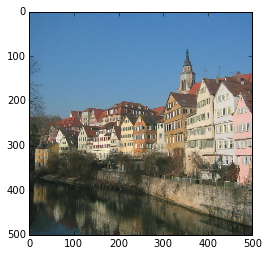

In [33]:
rawim, origim = prep_image(original)
plt.imshow(rawim)

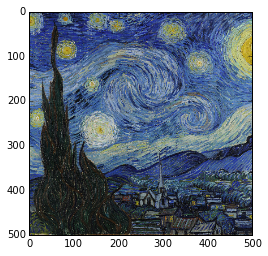

In [35]:
rawim, styleim = prep_image(styleimage)
plt.imshow(rawim)

In [18]:
p = T.tensor4()
a = T.tensor4()
x = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

In [20]:
loss = []
loss.append(0.001 * content_loss(p, x, net['conv4_2']))
loss.append(0.2 * style_loss(a, x, net['conv1_1']))
loss.append(0.2 * style_loss(a, x, net['conv2_1']))
loss.append(0.2 * style_loss(a, x, net['conv3_1']))
loss.append(0.2 * style_loss(a, x, net['conv4_1']))
loss.append(0.2 * style_loss(a, x, net['conv5_1']))

In [21]:
grad = T.grad(sum(loss), x)

In [27]:
updates = lasagne.updates.adam([grad], [x], learning_rate=10)

In [28]:
paint = theano.function([], loss, updates=updates, givens={p:theano.shared(origim), a:theano.shared(styleim)})

In [29]:
x.set_value(origim)

In [30]:
for i in range(500):
    if i % 10 == 0:
        print(i)    
    paint()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


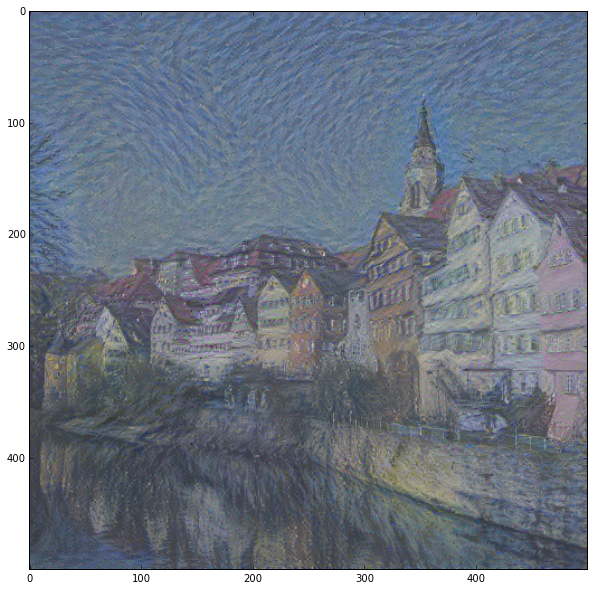

In [31]:
plt.figure(figsize=(10, 10))
c = x.get_value()
c = np.swapaxes(np.swapaxes(c[0], 0, 1), 1, 2)
c = c-c.min()
c = c/c.max()
plt.imshow(c[:,:,::-1])